In [1]:
import pandas as pd
import numpy as np
import os
import math

# visuals
import matplotlib.pyplot as plt

import seaborn as sns
from seaborn import heatmap

# .py files
import wrangle as wr

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:

import xgboost


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import heatmap
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import statistics


import xgboost as xgb
from sklearn.metrics import mean_squared_error

# data split
from sklearn.model_selection import train_test_split

# sklearn metrics
from sklearn.metrics import accuracy_score, precision_score,recall_score


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# importing data

In [3]:
df = pd.read_csv('neo_v2.csv')

# checking data and prepping

In [4]:
# they all orbit earth
df = df.drop(columns = 'orbiting_body')

In [5]:
# these are all exlcuded from the sentry automated collison monitoring system
df = df.drop(columns = 'sentry_object')

In [6]:
df.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,False


In [7]:
df['hazardous'] = df['hazardous'].astype(int)

In [8]:
df.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,0


In [9]:
# checking to make sure data is fine to work with
df.dtypes

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
absolute_magnitude    float64
hazardous               int64
dtype: object

# the goal of this project is to see wether or not we can classify a asteroid as hazardous 

In [10]:
len(df.columns)

8

In [11]:
numerical = df.select_dtypes(include = 'number')
len(numerical.columns)

7

In [12]:
categorical = df.select_dtypes(exclude = 'number')
len(categorical.columns)

1

In [13]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000


# exploring numericals

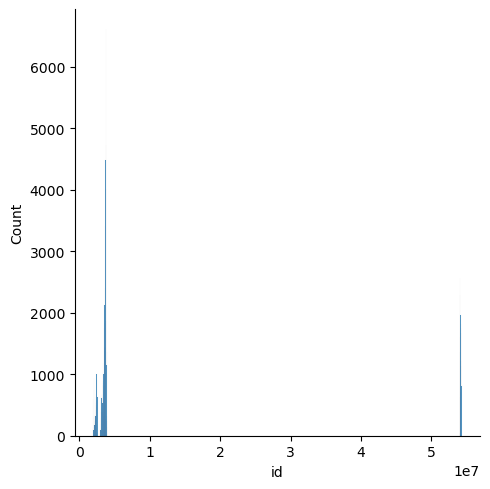

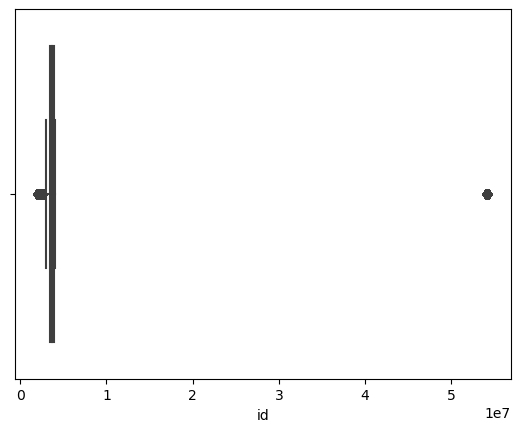

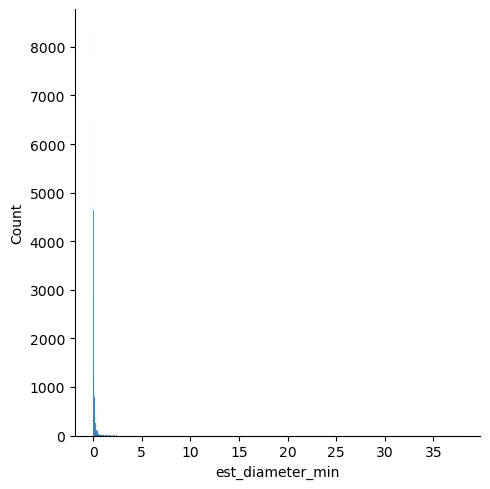

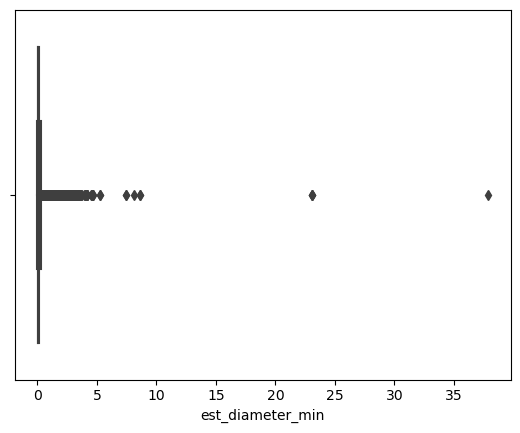

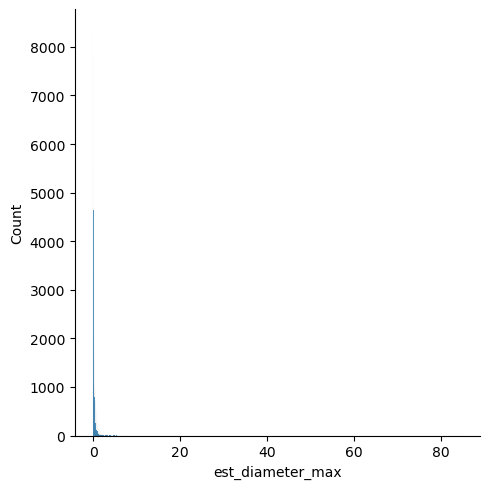

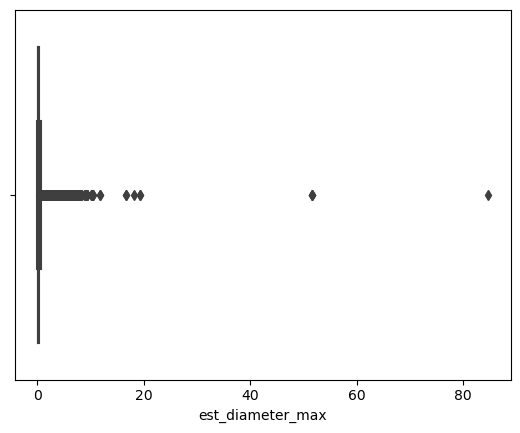

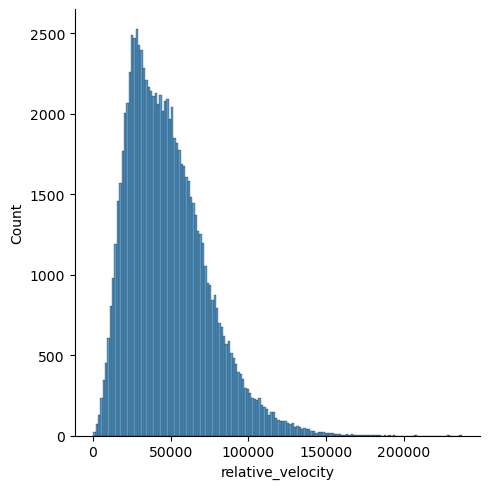

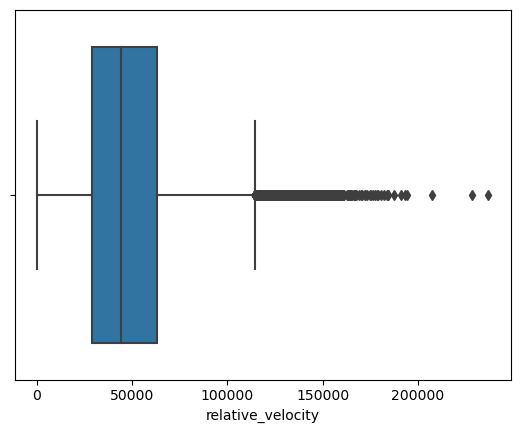

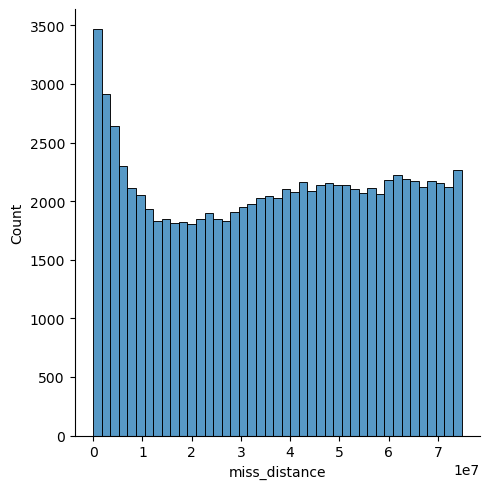

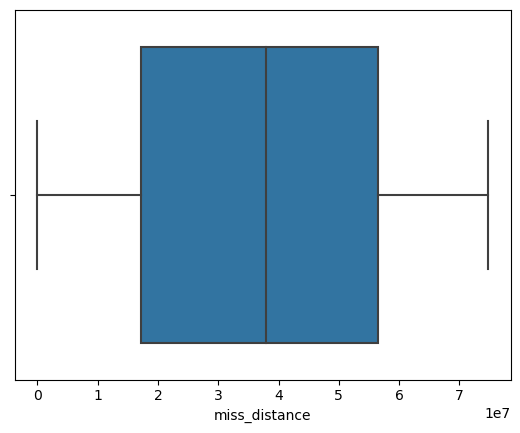

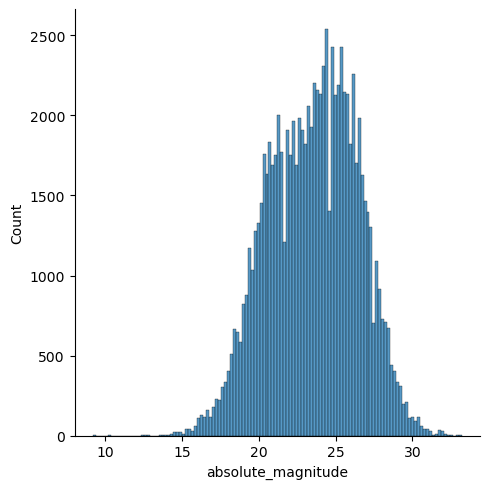

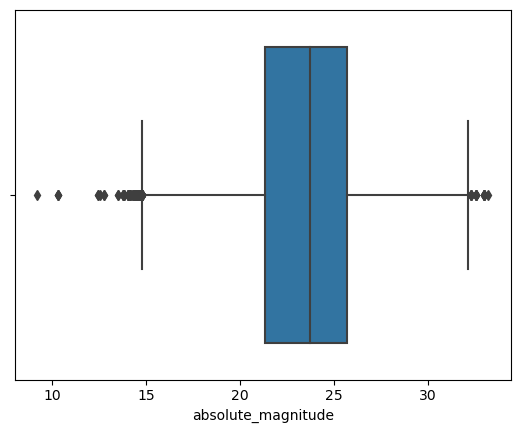

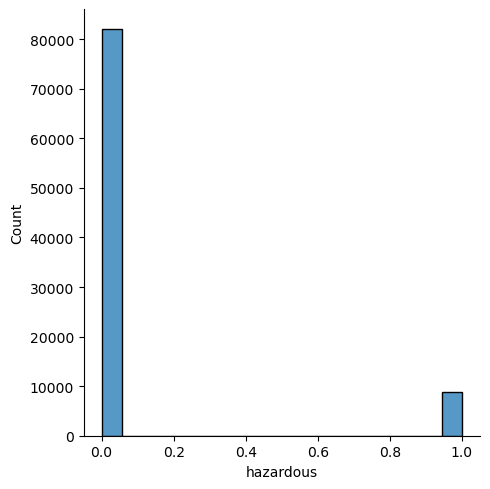

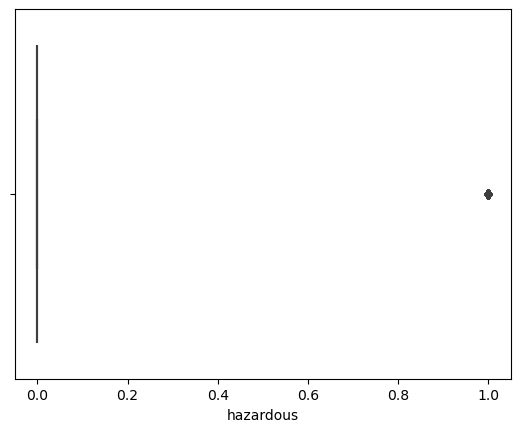

In [14]:
for col in numerical.columns:
    
    sns.displot(data= numerical,x = col)
    
    plt.show()
    
    
    # box plot, outlier check
    sns.boxplot(data= numerical,x = col)
    
    
    plt.show()
    

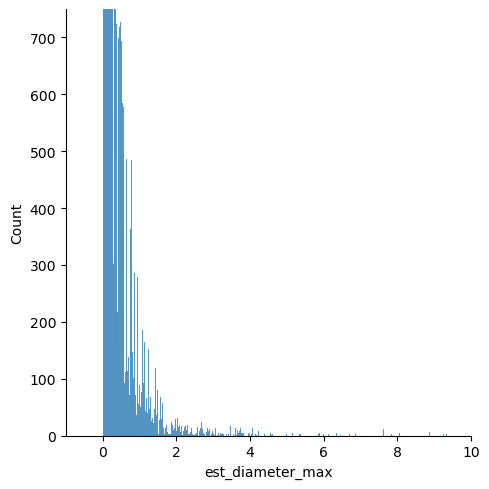

In [15]:
sns.displot(data= numerical,x = 'est_diameter_max')
plt.ylim(0,750)
plt.xlim(-1,10)
plt.show()
    

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
* There are two data points with outliers `min diameter`
* There are two data points with outliers `max diameter`(most likely the same two)
* more of data points have a near miss of about 1 or less


# exploring categoricals

In [16]:
categorical.head(1)

,name
0,162635 (2000 SS164)


In [17]:
# sns.countplot(data= categorical,x = "hazardous")
# plt.show()

<div class="alert alert-block alert-info">
<b>Hazardous:</b>  we have found more benign near earth objects than hazardous

# train split data

In [18]:
def split_data(df,strat):
    ''' 
    splits data frame and returns a train, validate, 
    and test data frame stratified on churn 
    '''
    
    # split df into train_validate and test
    train_validate, test = train_test_split(df,test_size =.2, 
                                             random_state = 42,
                                             stratify = df[strat])
    
    # split train_validate into train and validate
    train, validate = train_test_split(train_validate,
                                      test_size = .3,
                                      random_state = 42,
                                      stratify = train_validate[strat])
                                            
    # reset index for train validate and tes
    train.reset_index(drop=True, inplace=True)
    validate.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    print (train.shape,test.shape,validate.shape)
    return train, validate, test

In [19]:
# checking to see the shape and checking the data frames

In [20]:
train,validate, test = split_data(df,'hazardous')

(50867, 8) (18168, 8) (21801, 8)


In [21]:
train.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2512245,512245 (2016 AU8),0.288772,0.645714,29196.269134,3.049479e+07,19.82,0


In [22]:
test.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2474532,474532 (2003 VG1),0.472667,1.056915,21779.237137,3.443050e+07,18.75,0


In [23]:
validate.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3704141,(2015 AY245),0.168483,0.376738,23575.847178,3.791253e+07,20.99,1


# multi_variate

In [24]:
matrix = train.corr()

<AxesSubplot:>

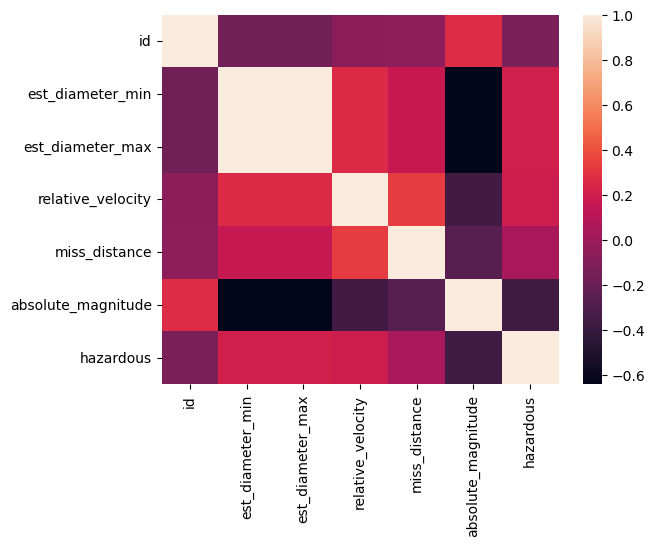

In [25]:
heatmap(matrix)


<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
* hazardous has a negative correlation to absoulte_magnitude
* hazardous has a positive correlation to `relative_velocity`, `diameter_max`, and `diameter_min`

* `absolute_magnitude` has a strong negative correlation with diameter. the less visablity an object has the more likely it is to be smaller.
* `rel_velocity` and the `diameter` are correlated

<div class="alert alert-block alert-success">
<b>Questions:</b>
    
* if i group hazardous and not hazardous, will the max diameter mean be different between the two?
* if i group hazardous and not hazardous, will there be a significant differce in absolute magnitude
* is the correlation between diameter and hazardous significant


# explore questions

### how many objects are hazardous and how many are inert

In [26]:
haz = df[df.hazardous == 1]
safe = df[df.hazardous == 0]

In [27]:
len(haz) / len(safe)
# 10 percent of our data is dangerous

0.10781013707985755

In [28]:
# i want to add gray spots to make it look like an astroid

In [29]:
### if i group hazardous and not hazardous, will the min diameter mean be different between the two?

(0.0, 100.0)

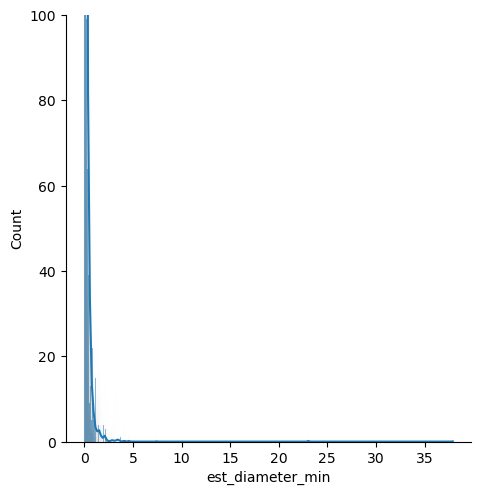

In [30]:
sns.displot(data = safe.est_diameter_min,kde = 'line')
plt.ylim(0,100)

(0.0, 100.0)

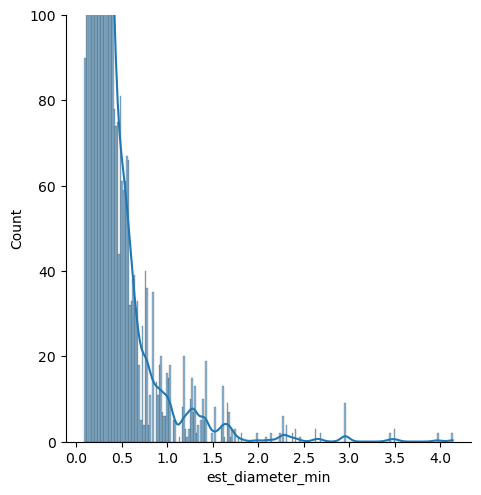

In [31]:
sns.displot(data = haz.est_diameter_min,kde = 'line')
plt.ylim(0,100)

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
$Ho$ : Mean of est_diameter_min of astroids that are hazardous = Mean of est_diameter_min of that are NOT hazardous

$Ha$ : Mean of est_diameter_min of astroids that are hazardous =! Mean of est_diameter_min of that are NOT hazardous

In [32]:
saf_min = safe.est_diameter_min

In [33]:
saf_min.mean()

0.10945994486417701

In [34]:
haz_min = haz.est_diameter_min

In [35]:
haz_min.mean()

0.2941340690233259

In [36]:
t, p= mannwhitneyu(haz_min, saf_min)

In [37]:
print('Statistics=%.2f, p=%.2f' % (t, p))


Statistics=627036894.00, p=0.00


In [38]:
a = 0.05
# conclusion
if p < a:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
* splitting the groups into safe and not safe objects, you can see that the there is a significant mean difference in the min diameter meaning this may have some influence in our model



# if i group hazardous and not hazardous, will there be a significant differce in absolute magnitude

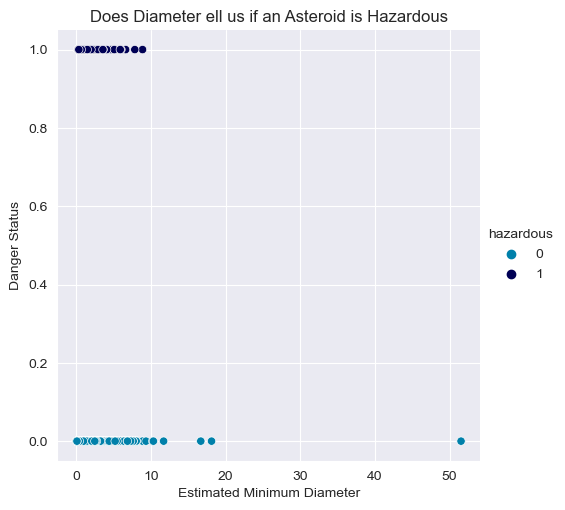

In [39]:
sns.set_style('darkgrid')
sns.relplot(data = train, x = 'est_diameter_max',y= 'hazardous',hue = "hazardous",palette = "ocean_r")
plt.title('Does Diameter ell us if an Asteroid is Hazardous')
plt.ylabel('Danger Status')
plt.xlabel('Estimated Minimum Diameter')
 

None

(0.0, 100.0)

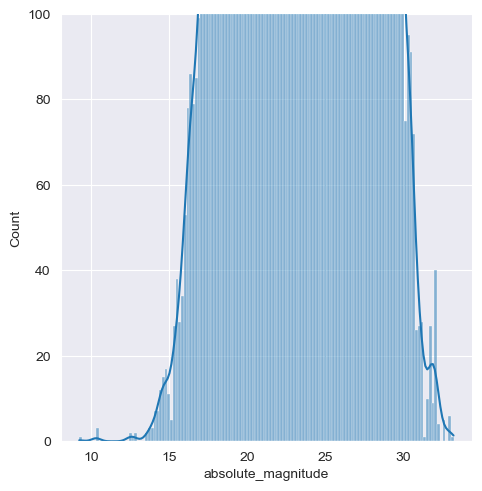

In [40]:
sns.displot(data = safe.absolute_magnitude,kde = 'line')
plt.ylim(0,100)

(0.0, 100.0)

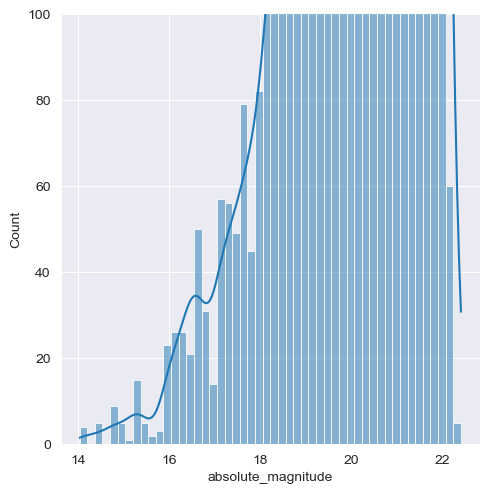

In [41]:
sns.displot(data = haz.absolute_magnitude,kde = 'line')
plt.ylim(0,100)

In [42]:
haz_mag = haz.absolute_magnitude 

In [43]:
saf_mag = safe.absolute_magnitude 

In [44]:
print(haz_mag.var())
print(saf_mag.var())

1.8000944781022008
7.846715845803671


In [45]:
t, p = stats.ttest_ind(haz_mag, saf_mag, equal_var=False)

t, p

(-206.14921177684386, 0.0)

In [46]:
# conclusion
if p < a:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
* splitting the groups into safe and not safe objects, you can see that the there is a significant mean difference in the absolute magnitude meaning this may have some influence in our model
* the visbility of an object plays a roll into categorizing it as safe or not


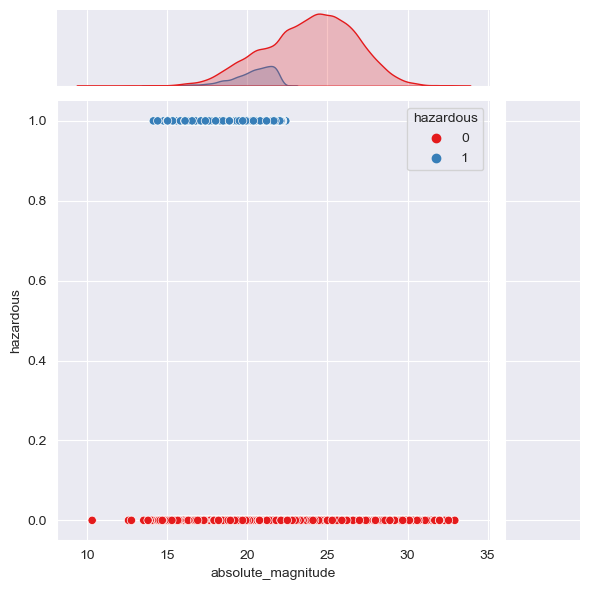

In [49]:
sns.jointplot(data = train, x = 'absolute_magnitude', y = 'hazardous',hue = 'hazardous',palette = 'Set1' )

In [50]:
# the brighter you are the less chance of being hazardous

# Modeling 

In [51]:
def x_and_y(train,validate,test,target):
    
    """
    splits train, validate, and target into x and y versions
    """

    x_train = train.drop(columns= target)
    y_train = train[target]

    x_validate = validate.drop(columns= target)
    y_validate = validate[target]

    x_test = test.drop(columns= target)
    y_test = test[target]
    
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)


    return x_train,y_train,x_validate,y_validate,x_test, y_test

In [52]:
x_train,y_train,x_validate,y_validate,x_test, y_test = x_and_y(train,validate,test,'hazardous')

# selecting model features

In [53]:
x_train = x_train.drop(columns = ['id','name'])
x_validate = x_validate.drop(columns = ['id','name'])
x_test= x_test.drop(columns = ['id','name'])

### baseline

In [51]:
# Calculate the baseline prediction
baseline_pred = [statistics.mode(y_train['hazardous'])] * len(y_train['hazardous'])

# Calculate the accuracy score
baseline_accuracy = accuracy_score(y_train['hazardous'], baseline_pred)
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

# Calculate the precision score
baseline_precision = precision_score(y_train['hazardous'], baseline_pred, average='macro')
print(f"Baseline Precision: {baseline_precision:.2f}")

Baseline Accuracy: 0.90
Baseline Precision: 0.45


In [79]:
def baseline(y_train,y_validate,target):
    
    '''a function to return our baseline and create a dataframe to hold all the models and their features'''
    
    # turning our series into a data frame
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    
    
     # predict target value mode
    train_mode = y_train[target].mode()[0]
    validate_mode = y_validate[target].mode()[0]
   
    # predict tax value mode
    y_train[target + '_mode_baseline'] = train_mode
    y_validate[target + '_mode_baseline'] = validate_mode
    
    matching_values = (y_train['hazardous'] == y_train['hazardous_mode_baseline']).sum()

  # Calculate the baseline prediction
    baseline_pred = [statistics.mode(y_train['hazardous'])] * len(y_train['hazardous'])

    # Calculate the accuracy score
    baseline_accuracy = accuracy_score(y_train['hazardous'], baseline_pred)
    print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

    # Calculate the recall score
    baseline_recall = recall_score(y_train['hazardous'], baseline_pred, average='macro')
    print(f"Baseline Recall: {baseline_recall:.2f}")
    
    # creating a new series to hold our results of all model performance
    evals = {'Recall': [baseline_recall], 'model': ['baseline']}

    # creating a data frame from our series to pass on
    evals = pd.DataFrame(data=evals)
    
    return y_train,y_validate,evals

In [80]:
y_train,y_validate,evals = baseline(y_train,y_validate,'hazardous')

Baseline Accuracy: 0.90
Baseline Recall: 0.50


In [81]:
evals

,Recall,model
0,0.5,baseline


# decision tree

In [82]:
def decision_tree(x_train, y_train, x_validate, y_validate, x_test, y_test, md):
    clf = DecisionTreeClassifier(random_state=42)
    results = []
    for i in range(1, md+1):
        clf = DecisionTreeClassifier(max_depth=i, random_state=42)
        clf.fit(x_train, y_train['hazardous'])
        
        # Accuracy and precision for the training data
        y_train_pred = clf.predict(x_train)
        train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
        train_recall = recall_score(y_train['hazardous'], y_train_pred)
       
         # Accuracy and precision for the validate data
        y_validate_pred = clf.predict(x_validate)
        validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
        validate_recall = recall_score(y_validate['hazardous'], y_validate_pred)
    
        # Accuracy and precision for the test data
        y_test_pred = clf.predict(x_test)
        test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
        test_recall = recall_score(y_test['hazardous'], y_test_pred)
        
        results.append({'Max Depth': i, 
                        'Train Accuracy': train_accuracy,
                        'Train Recall': train_recall,
                        'Validate Accuracy': validate_accuracy,
                        'validate Recall': validate_recall,
                        'Test Accuracy': test_accuracy,
                        'Test Recall': test_recall})
        
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
results = decision_tree(x_train, y_train, x_validate,y_validate, x_test, y_test, 20)

In [86]:
results.sort_values(by = "Test Recall").tail(1)

,Max Depth,Train Accuracy,Train Recall,Validate Accuracy,validate Recall,Test Accuracy,Test Recall
19,20,0.954587,0.565455,0.903353,0.295476,0.902466,0.305995


In [57]:
# take aways: 
# a decision tree with the max depth of 20 has the highest recall as .30%

In [90]:
def add_dt_test(x_train, y_train, x_test, y_test, md,evals):
    
    clf = DecisionTreeClassifier(max_depth=md, random_state=42)
    
    clf.fit(x_train, y_train['hazardous'])
    
    # Accuracy and precision for the test data
    y_test_pred = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
    test_recall = recall_score(y_test['hazardous'], y_test_pred)
    
    decision = {'Recall': test_recall, 'model': 'decision tree'}
    evals = evals.append(decision, ignore_index = True)
    
    return evals
    
    
    

In [94]:
evals= add_dt_test(x_train, y_train, x_test, y_test, 20,evals)


In [95]:
evals

,Recall,model
0,0.500000,baseline
1,0.305995,decision tree


# random forest

In [97]:
def random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, md):
    clf = RandomForestClassifier(random_state=42)
    results = []
    for i in range(1, md+1):
        clf = RandomForestClassifier(max_depth=i, random_state=42)
        
        clf.fit(x_train, y_train['hazardous'])
        
        # Accuracy and precision for the training data
        y_train_pred = clf.predict(x_train)
        train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
        train_recall = recall_score(y_train['hazardous'], y_train_pred)
       
         # Accuracy and precision for the validate data
        y_validate_pred = clf.predict(x_validate)
        validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
        validate_recall = recall_score(y_validate['hazardous'], y_validate_pred)
    
        # Accuracy and precision for the test data
        y_test_pred = clf.predict(x_test)
        test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
        test_recall = recall_score(y_test['hazardous'], y_test_pred)
        
        results.append({'Max Depth': i, 
                        'Train Accuracy': train_accuracy,
                        'Train Recall': train_recall,
                        'Validate Accuracy': validate_accuracy,
                        'validate Recall': validate_recall,
                        'Test Accuracy': test_accuracy,
                        'Test Recall': test_recall})
    results_df = pd.DataFrame(results)
    return results_df

In [98]:
results_df = random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, 20)

In [100]:
results_df.sort_values(by = 'Test Recall').tail(1)

,Max Depth,Train Accuracy,Train Recall,Validate Accuracy,validate Recall,Test Accuracy,Test Recall
19,20,0.962746,0.617778,0.917252,0.279925,0.920244,0.313348


In [101]:
def random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, n_estimators, max_depth):
    results = []
    for n in n_estimators:
        for d in max_depth:
            clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
            clf.fit(x_train, y_train['hazardous'])

            # Accuracy and precision for the training data
            y_train_pred = clf.predict(x_train)
            train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
            train_recall = recall_score(y_train['hazardous'], y_train_pred)

            # Accuracy and precision for the validate data
            y_validate_pred = clf.predict(x_validate)
            validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
            validate_recall = recall_score(y_validate['hazardous'], y_validate_pred)

            # Accuracy and precision for the test data
            y_test_pred = clf.predict(x_test)
            test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
            test_recall = recall_score(y_test['hazardous'], y_test_pred)

            results.append({'n_estimators': n,
                            'max_depth': d,
                            'Train Accuracy': train_accuracy,
                            'Train Recall': train_recall,
                            'Validate Accuracy': validate_accuracy,
                            'validate Recall': validate_recall,
                            'Test Accuracy': test_accuracy,
                            'Test Recall': test_recall})
    results_df = pd.DataFrame(results)
    return results_df

In [102]:
n_estimators = range(1, 10)
max_depth = range(1, 10)


In [103]:
results_df = random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, n_estimators, max_depth)


In [104]:
results_df.sort_values(by = 'Test Recall').tail(1)

,n_estimators,max_depth,Train Accuracy,Train Recall,Validate Accuracy,validate Recall,Test Accuracy,Test Recall
4,1,5,0.912065,0.188687,0.910371,0.18426,0.912869,0.199095


In [ ]:
# these setting gave us our best test precision

# knn 

In [105]:
def get_knn(x_train, y_train, x_validate, y_validate, x_test, y_test, nn):
    
    weights = ['uniform', 'distance']
    results = []
    for i in range(1, nn+1):
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=nn, weights= w )

            knn.fit(x_train, y_train['hazardous'])
        
            # Accuracy and precision for the training data
            y_train_pred = knn.predict(x_train)
            train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
            train_recall = recall_score(y_train['hazardous'], y_train_pred)
       
            # Accuracy and precision for the validate data
            y_validate_pred = knn.predict(x_validate)
            validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
            validate_recall = recall_score(y_validate['hazardous'], y_validate_pred)
    
            # Accuracy and precision for the test data
            y_test_pred = knn.predict(x_test)
            test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
            test_recall = recall_score(y_test['hazardous'], y_test_pred)
        
            results.append({'N_neighbors': i, 
                        'Weights': w,
                        'Train Accuracy': train_accuracy,
                        'Train Recall': train_recall,
                        'Validate Accuracy': validate_accuracy,
                        'validate Recall': validate_recall,
                        'Test Accuracy': test_accuracy,
                        'Test Recall': test_recall})
        
    results_df = pd.DataFrame(results)
    return results_df

In [106]:
results_df = get_knn(x_train, y_train, x_validate, y_validate, x_test, y_test, 40)


In [107]:
results_df.sort_values(by = 'Test Recall').tail(1)

,N_neighbors,Weights,Train Accuracy,Train Recall,Validate Accuracy,validate Recall,Test Accuracy,Test Recall
79,40,distance,1.0,1.0,0.904958,0.03393,0.904668,0.029412


# XGBoost

In [111]:
results.sort_values(by = 'Test Recall').tail(1)

,scale_pos_weight,learning_rate,max_depth,Train Accuracy,Train Recall,Validate Accuracy,Validate Recall,Test Accuracy,Test Recall
7,5,0.01,1,0.773783,0.993131,0.772442,0.990575,0.775099,0.993778


In [69]:
clf_xgb = xgb.XGBClassifier(objective ='binary:logistic', 
                                        seed = 42,
                                        max_depth = 3,    
                                        scale_pos_weight= 5,
                                        learning_rate = .01,
                                        subsample = .9,
                                        colsample_bytree = .5,
                                        n_jobs = 10)

In [70]:
clf_xgb.fit(x_train,y_train['hazardous'],verbose = True)
None

In [68]:
results.sort_values(by = 'Test Recall').tail(1)

,scale_pos_weight,learning_rate,max_depth,Train Accuracy,Train Recall,Validate Accuracy,Validate Recall,Test Accuracy,Test Recall
7,5,0.01,3,0.786482,0.989495,0.784918,0.983506,0.78996,0.988122


In [71]:
preds = clf_xgb.predict(x_test)

In [72]:
preds

array([1, 0, 0, ..., 0, 0, 0])

In [73]:
test_accuracy = accuracy_score(y_test['hazardous'],preds)
test_recall = recall_score(y_test['hazardous'],preds)

In [74]:
test_accuracy ,test_recall

(0.7899603698811096, 0.9881221719457014)

In [76]:
confusion_matrix(y_test['hazardous'],preds)

array([[12605,  3795],
       [   21,  1747]])

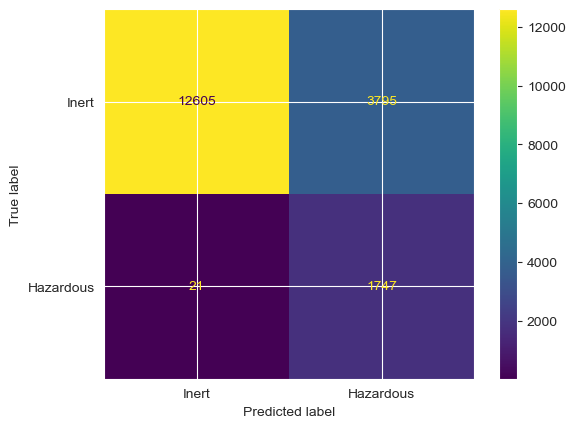

In [77]:
plot_confusion_matrix(clf_xgb,
                      x_test,
                      y_test,
                      values_format = 'd',
                       display_labels = [ 'Inert','Hazardous'])
                      

In [78]:
1747/( 1747+ 21)

0.9881221719457014

In [63]:
def xg_boost1(x_train, y_train, x_validate, y_validate, x_test, y_test, max_depth, scale_pos_weight, learning_rate):
    results = []

    for md in max_depth:
        for sw in scale_pos_weight:
            for lr in learning_rate:
                clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                            random_state=42,
                                            max_depth=md,
                                            scale_pos_weight=sw,
                                            learning_rate=lr,
                                            subsample=.9,
                                            colsample_bytree=.5,
                                            n_jobs=10)

                clf_xgb.fit(x_train, y_train['hazardous'], verbose=False)

                # Accuracy and recall for the training data
                y_train_pred = clf_xgb.predict(x_train)
                train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
                train_recall = recall_score(y_train['hazardous'], y_train_pred)

                # Accuracy and recall for the validate data
                y_validate_pred = clf_xgb.predict(x_validate)
                validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
                validate_recall = recall_score(y_validate['hazardous'], y_validate_pred)

                # Accuracy and recall for the test data
                y_test_pred = clf_xgb.predict(x_test)
                test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
                test_recall = recall_score(y_test['hazardous'], y_test_pred)

                # Append results to the list
                results.append({'scale_pos_weight': sw,
                                'learning_rate': lr,
                                'max_depth': md,
                                'Train Accuracy': train_accuracy,
                                'Train Recall': train_recall,
                                'Validate Accuracy': validate_accuracy,
                                'Validate Recall': validate_recall,
                                'Test Accuracy': test_accuracy,
                                'Test Recall': test_recall})

                # Print results
                print(f"max_depth: {md}, scale_pos_weight: {sw}, learning_rate: {lr}, Train Recall: {train_recall:.4f}, Validate Recall: {validate_recall:.4f}, Test Recall: {test_recall:.4f}")

    # Convert results list to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df

In [64]:
max_depth = [3,4,5]
scale_pos_weight=[1,3,5]
learning_rate = [.1,.01,.05]

In [108]:
results = xg_boost1(x_train, y_train, x_validate, y_validate, x_test, y_test, max_depth,scale_pos_weight,learning_rate)
None

max_depth: 1, scale_pos_weight: 1, learning_rate: 0.1, Train Recall: 0.1154, Validate Recall: 0.1008, Test Recall: 0.1205
max_depth: 1, scale_pos_weight: 1, learning_rate: 0.01, Train Recall: 0.0000, Validate Recall: 0.0000, Test Recall: 0.0000
max_depth: 1, scale_pos_weight: 1, learning_rate: 0.05, Train Recall: 0.0000, Validate Recall: 0.0000, Test Recall: 0.0000
max_depth: 1, scale_pos_weight: 3, learning_rate: 0.1, Train Recall: 0.9465, Validate Recall: 0.9444, Test Recall: 0.9485
max_depth: 1, scale_pos_weight: 3, learning_rate: 0.01, Train Recall: 0.9903, Validate Recall: 0.9892, Test Recall: 0.9893
max_depth: 1, scale_pos_weight: 3, learning_rate: 0.05, Train Recall: 0.9762, Validate Recall: 0.9713, Test Recall: 0.9762
max_depth: 1, scale_pos_weight: 5, learning_rate: 0.1, Train Recall: 0.9889, Validate Recall: 0.9826, Test Recall: 0.9870
max_depth: 1, scale_pos_weight: 5, learning_rate: 0.01, Train Recall: 0.9931, Validate Recall: 0.9906, Test Recall: 0.9938
max_depth: 1, scale

max_depth: 8, scale_pos_weight: 3, learning_rate: 0.01, Train Recall: 0.8477, Validate Recall: 0.7983, Test Recall: 0.8043
max_depth: 8, scale_pos_weight: 3, learning_rate: 0.05, Train Recall: 0.8733, Validate Recall: 0.7743, Test Recall: 0.8009
max_depth: 8, scale_pos_weight: 5, learning_rate: 0.1, Train Recall: 0.9895, Validate Recall: 0.9284, Test Recall: 0.9248
max_depth: 8, scale_pos_weight: 5, learning_rate: 0.01, Train Recall: 0.9917, Validate Recall: 0.9713, Test Recall: 0.9762
max_depth: 8, scale_pos_weight: 5, learning_rate: 0.05, Train Recall: 0.9915, Validate Recall: 0.9614, Test Recall: 0.9615
max_depth: 9, scale_pos_weight: 1, learning_rate: 0.1, Train Recall: 0.2931, Validate Recall: 0.2111, Test Recall: 0.2296
max_depth: 9, scale_pos_weight: 1, learning_rate: 0.01, Train Recall: 0.1172, Validate Recall: 0.0947, Test Recall: 0.1058
max_depth: 9, scale_pos_weight: 1, learning_rate: 0.05, Train Recall: 0.2117, Validate Recall: 0.1668, Test Recall: 0.1804
max_depth: 9, scal

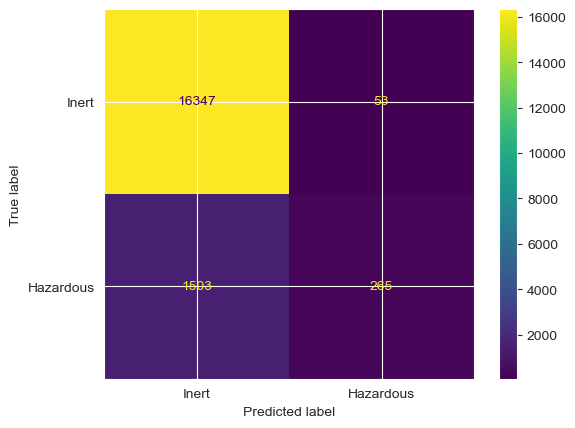

In [313]:
plot_confusion_matrix(clf_xgb,
                      x_test,
                      y_test,
                      values_format = 'd',
                       display_labels = [ 'Inert','Hazardous'])
                      